# Fixed Point Grover's algorithm

We have seen that the probability of measuring the marked state $a$ after $t$ steps of Grover's algorithm is $\sin^2((2t+1)\theta)$. 
This means that if we perform too many steps we decrease the probability of measuring $a$.
It turns out that a modification of Grover's algorithm allows us to avoid this, and produces an algorithm which has $a$ as a fixed point, so that the more we run the algorithm, the more accurate result we get.
In this coursework, you will implement such an algorithm and verify its properties.

## Setup

Make sure you have installed Qiskit following [https://docs.quantum.ibm.com/start/install](https://docs.quantum.ibm.com/start/install) and install also the AerSimulator with `pip install qiskit-aer`

Run these cells to import the needed modules

In [102]:
# Built-in modules
import math
import warnings

warnings.filterwarnings("ignore")

import qiskit

# Imports from Qiskit
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram

from qiskit_aer import AerSimulator

## Generalised V

We define an operator $S(\beta)$ that acts on $n+1$ qubits, such that
$$
S(\beta)|x\rangle|0\rangle = e^{-i\beta/2}V(\beta)|x\rangle|0\rangle\,,\quad 
V(\beta) = \exp(i\beta |a\rangle\langle a|)= I - (1-e^{i\beta})|a\rangle\langle a|\,.
$$
Here $\beta$ is a given angle and note that $V(\pm \pi)$ coincides with $V$ of the lecture. 

### Exercise 1: Implement $S(\beta)$ (40 points)
Create a function which takes as inputs $\beta,a$ and returns a Qiskit circuit for $S(\beta)$ by implementing the following circuit:

<img src="s_beta.png" alt="S(beta) circuit" style="height: 300px; width:400px;"/>

where $U=U_f$ is as usual the oracle such that 
$$
U_f|a\rangle|y\rangle=|a\rangle|y\oplus 1\rangle
\,,\quad 
U_f|a_\perp\rangle|y\rangle=|a_\perp\rangle|y\rangle
$$
for any $\langle a|a_\perp\rangle=0$ and
$$
Z_\beta
=
\exp\left(-i\frac{\beta}{2}Z\right)
$$
with $Z$ the Pauli matrix.

In [157]:
from qiskit.circuit.library import MCMT, XGate


def grover_oracle(marked_state):
    """Implements the Grover's oracle for a marked state a

    Parameters:
        marked_state (str): Bit string of the marked state (a) of the oracle

    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle
    """
    num_qubits = len(marked_state)

    qc = QuantumCircuit(num_qubits)
    # Reverse the target bit string as qiskit has a different qubit numbering convention
    rev_target = marked_state[::-1]

    # Find the indices of all the '0' elements in bit-string
    zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]

    # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
    # where the target bit-string has a '0' entry
    qc.x(zero_inds)
    qc.compose(MCMT(XGate(), num_qubits - 1, 1), inplace=True)
    qc.x(zero_inds)

    return qc


def create_s(marked_state, beta):
    """Implement S(\beta)

    Parameters:
        marked_state (str): Marked state of oracle (a)
        beta (float): angle

    Returns:
        QuantumCircuit: Quantum circuit representing S(\beta)
    """
    num_qubits = len(marked_state)
    qc = QuantumCircuit(num_qubits)

    u = grover_oracle(marked_state).to_gate()
    qc.append(u, range(num_qubits))
    qc.rz(beta, num_qubits - 1)
    qc.append(u, range(num_qubits))

    return qc

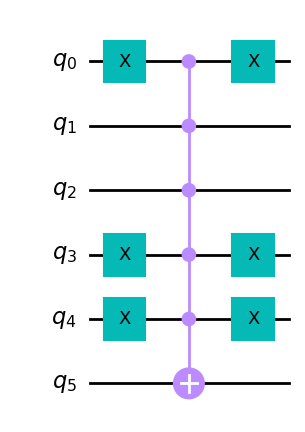

In [158]:
# Here we test if the circuits look right

marked_state = "100110"
qc1 = grover_oracle(marked_state)
qc1.draw(output="mpl")

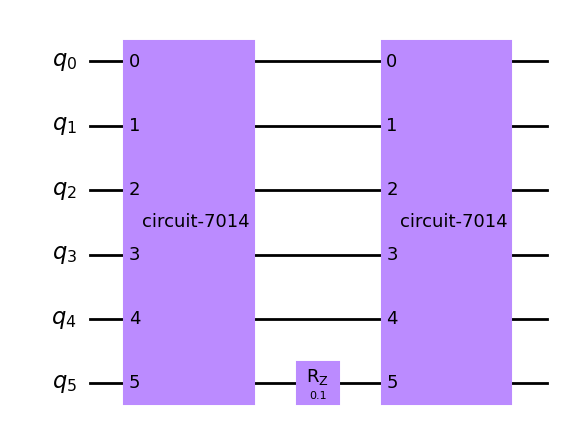

In [159]:
qc2 = create_s(marked_state, 0.1)
qc2.draw(output="mpl")

## Generalised inversion by the mean

We define the generalised inversion by the mean as
$$
W(\alpha)
=
e^{i\alpha/4}
(
I - (1-e^{-i\alpha})|\phi\rangle\langle\phi|
)
$$
with 
$$
|\phi\rangle
=
A|0\rangle^{\otimes n}
\,,\quad 
A = H^{\otimes n}
.
$$
For $\alpha=\pm$ it coincides with the inversion by the mean seen in the lecture up to a phase.

### Exercise 2: Implement $W(\alpha)$ (60 points)
Create a function which takes as inputs $\alpha$ and returns a Qiskit circuit for $W(\alpha)$ by implementing the following circuit:

<img src="w_alpha.png" alt="W(alpha) circuit" style="height: 300px; width:600px;"/>

where $A=H^{\otimes n}$, and

<img src="empty_cnot.png" alt="Negative CNOT " style="height: 50px; width:300px;"/>

Hint: to implement the multi-controlled CNOT gate you can use the Qiskit method `mcx`

In [167]:
from qiskit.circuit.library import MCMT


def create_w(alpha, num_qubits):
    """Implement W(\alpha)

    Parameters:
        alpha (float): angle
        num_qubits (int): number of qubits

    Returns:
        QuantumCircuit: Quantum circuit representing W(\alpha)
    """

    # First define the multiply-controlled multiply-targeted CNOT gate.
    multi_controlled_X = MCMT("x", num_ctrl_qubits=num_qubits - 2, num_target_qubits=2)
    MX = multi_controlled_X.to_gate()

    qc = QuantumCircuit(num_qubits)

    input_qubits = list(range(num_qubits - 1))
    two_last_qubits = [num_qubits - 2, num_qubits - 1]

    qc.h(input_qubits)
    qc.barrier()
    qc.rz(-alpha / 2, num_qubits - 2)
    # Added barriers for visual grouping of the parts of the circuit
    qc.barrier()
    qc.x(input_qubits[:-1])
    qc.append(MX, list(range(num_qubits)))
    qc.x(input_qubits[:-1])
    qc.barrier()
    qc.rz(-alpha / 2, two_last_qubits)
    qc.barrier()
    qc.x(input_qubits[:-1])
    qc.append(MX, list(range(num_qubits)))
    qc.x(input_qubits[:-1])
    qc.barrier()
    qc.rz(alpha, num_qubits - 2)
    qc.barrier()
    qc.h(input_qubits)

    return qc

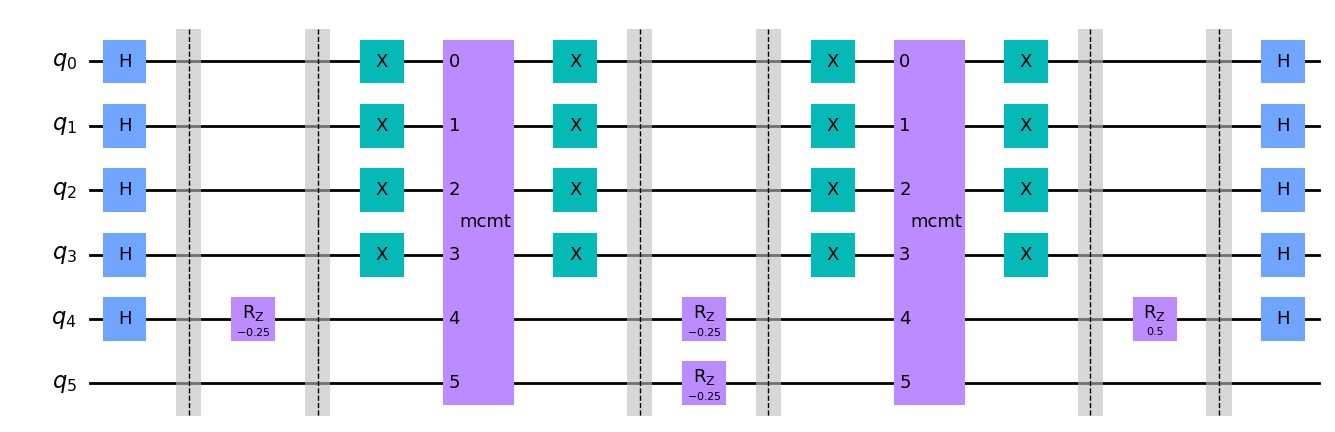

In [168]:
# Test if the shape of the circuit is correct
qc = create_w(0.5, 6)
qc.draw(output="mpl")

## The full algorithm 

The full circuit is given by
$$
G
=
\prod_{i=1}^l W(\alpha_j) S(\beta_j) 
$$
The angles $\alpha_j, \beta_j$ can be chosen in such a way that the success probability in finding $a$ increases with $l$. We can guarantee a probability greater than $1-\delta^2$ for $\delta\in (0,1]$ if we choose $L \ge \log(2/\delta) \sqrt{N}$ and the angles as defined below, with $L=2l+1$. Note the square root scaling with $N$ as in Grover's, to which the algorithm reduces when $\delta=1$.

In [169]:
def acot(x):
    return math.atan2(1, x)


def cheb(i, x):
    return math.cosh(i * math.acosh(x))


def gamma(L, delta):
    return 1.0 / cheb(1.0 / L, 1.0 / delta)


def alpha_fixed_point(j, l, delta):
    L = 2 * l + 1
    return 2 * acot(math.tan(2 * math.pi * j / L) * math.sqrt(1 - gamma(L, delta) ** 2))


def beta_fixed_point(j, l, delta):
    return -alpha_fixed_point(l - j + 1, l, delta)

In [170]:
def create_fixed_point_circuit(marked_state, num_steps, delta):
    """Implement G

    Parameters:
        marked_state (str): Marked state of oracle (a)
        num_steps (int): Number of steps of the algorithm (l)
        delta (float): Precision parameter in (0,1]

    Returns:
        QuantumCircuit: Quantum circuit G with input state preparation
    """
    # Compute the number of qubits in circuit
    num_qubits = len(marked_state)

    qc = QuantumCircuit(num_qubits + 1)

    # Prepare input state
    qc.h(list(range(num_qubits)))

    for j in range(num_steps):
        alpha = alpha_fixed_point(j + 1, num_steps, delta)
        beta = beta_fixed_point(j + 1, num_steps, delta)
        qc.compose(create_s(marked_state, beta), inplace=True)
        qc.compose(create_w(alpha, num_qubits), inplace=True)
    return qc

Now run this algorithm for $a=00101$, $\delta=0.5$ and varying number of steps. 

In [171]:
from qiskit import Aer, execute

# As instructed above, running for a varying number of steps
results = {}
for steps in range(10):
    fp_qc = create_fixed_point_circuit("00101", steps + 1, 0.5)
    fp_qc.measure_all()
    # fp_qc.draw(output="mpl", style="iqp")
    simulator = Aer.get_backend("qasm_simulator")
    results[steps] = execute(fp_qc, simulator, shots=1024).result()

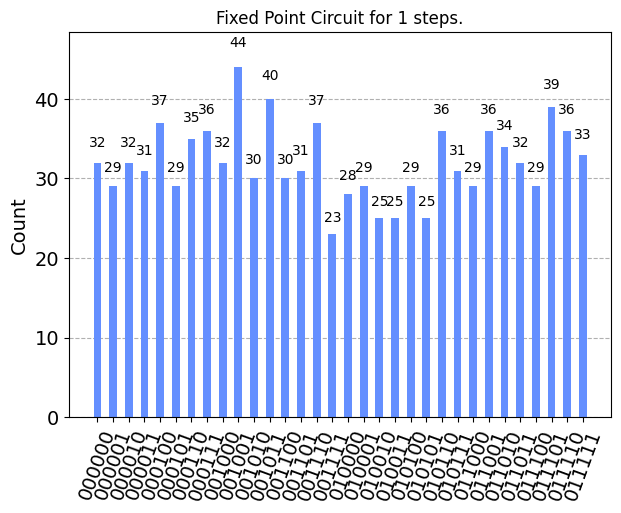

In [176]:
# For some reason it doesn't want to plot many histograms in one cell.

counts = results[0].get_counts()
plot_histogram(counts, title=f"Fixed Point Circuit for {1} steps.")

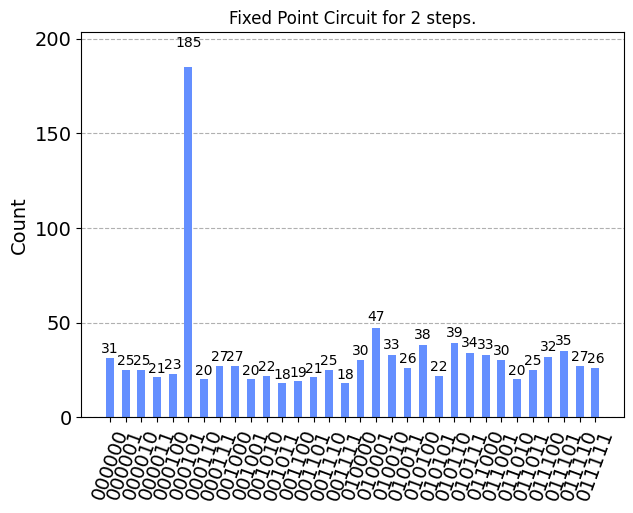

In [177]:
# For some reason it doesn't want to plot many histograms in one cell.

counts = results[1].get_counts()
plot_histogram(counts, title=f"Fixed Point Circuit for {2} steps.")

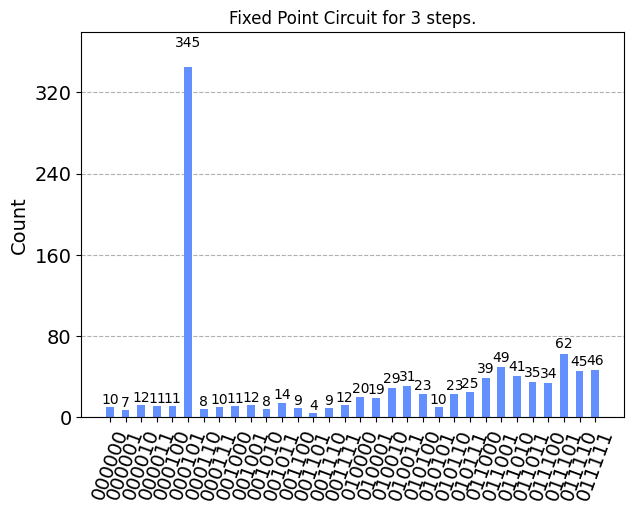

In [178]:
# For some reason it doesn't want to plot many histograms in one cell.

counts = results[2].get_counts()
plot_histogram(counts, title=f"Fixed Point Circuit for {3} steps.")

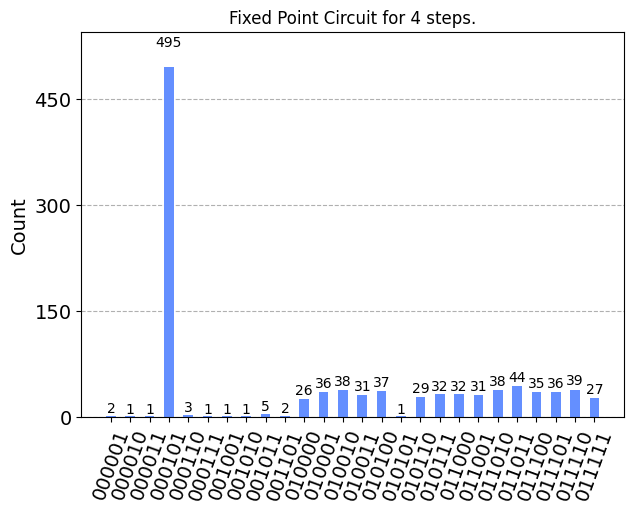

In [179]:
# For some reason it doesn't want to plot many histograms in one cell.

counts = results[3].get_counts()
plot_histogram(counts, title=f"Fixed Point Circuit for {4} steps.")

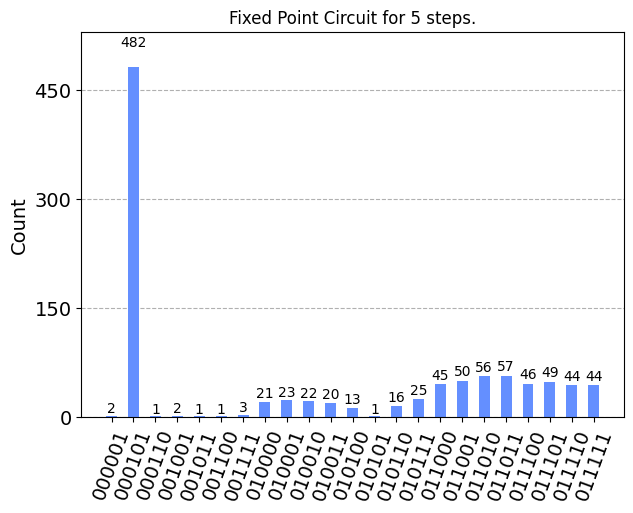

In [180]:
# For some reason it doesn't want to plot many histograms in one cell.

counts = results[4].get_counts()
plot_histogram(counts, title=f"Fixed Point Circuit for {5} steps.")

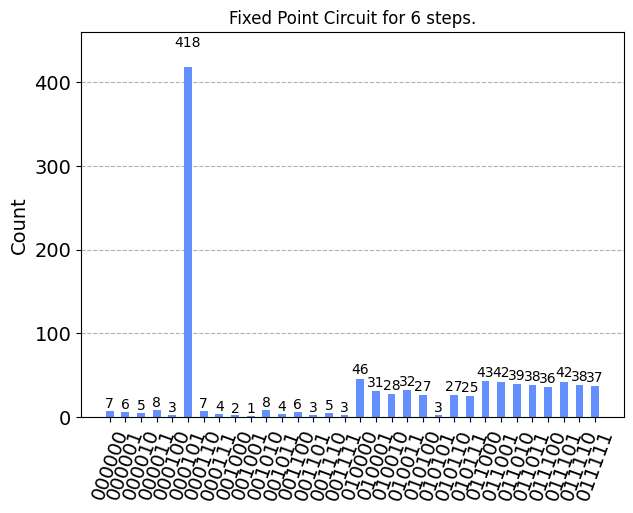

In [181]:
# For some reason it doesn't want to plot many histograms in one cell.

counts = results[5].get_counts()
plot_histogram(counts, title=f"Fixed Point Circuit for {6} steps.")

Compare with the case $\delta=1$ which corresponds to Grover's, to check the fixed point property.

In [165]:
# Probability of measuring a in Grover's
[math.sin((2 * t + 1) * math.asin(1 / math.sqrt(32))) ** 2 for t in range(10)]

[0.031249999999999993,
 0.25830078125,
 0.6024246215820311,
 0.896936535835266,
 0.9991823155432941,
 0.8596366611600389,
 0.5458919990273899,
 0.20991839986584915,
 0.014453075769287534,
 0.054174543096977154]

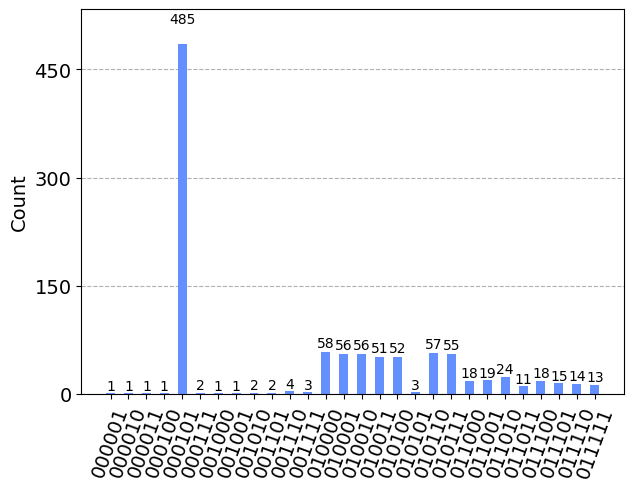

In [194]:
# Given the probabilities above, Grover's algorithm achieves the best performance for 4 steps.
# We can also see in the graph below that it is very good.
grover_qc = create_fixed_point_circuit("00101", 3, 1)
grover_qc.measure_all()
simulator = Aer.get_backend("qasm_simulator")
result = execute(grover_qc, simulator, shots=1024).result()
counts = result.get_counts()
plot_histogram(counts)

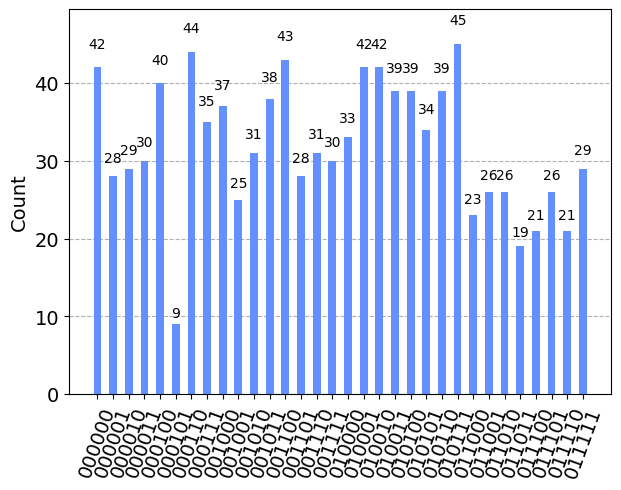

In [195]:
# If however, we increase the number of steps so that it is larger than
# the optimal 4, we can see that the performance starts to deteriorate.
# 6 here means that overall 7 steps of the algorhthm are performed.
grover_qc = create_fixed_point_circuit("00101", 6, 1)
grover_qc.measure_all()
simulator = Aer.get_backend("qasm_simulator")
result = execute(grover_qc, simulator, shots=1024).result()
counts = result.get_counts()
plot_histogram(counts)

As expected 8 steps of Grover's algorithm give a much worse estimate than say 5 steps, while the fixed point algorithm does not suffer from this problem.

## References

- https://learning.quantum.ibm.com/tutorial/grovers-algorithm
- [https://arxiv.org/abs/1409.3305](https://arxiv.org/abs/1409.3305).
- See also [https://arxiv.org/abs/2105.02859](https://arxiv.org/abs/2105.02859) for a more general perspective